# Unit 5 - Financial Planning

In [36]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings

%matplotlib inline

In [37]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Variables for personal portfolio analysis:

In [38]:
# Set current asset ticker symbol
ticker_BTC = 'BTC'  
ticker_ETH = 'ETH '  
ticker_SPY = 'SPY'   
ticker_AGG = 'AGG'  

# Set current asset names
name_BTC = 'Bitcoin'  
name_ETH = 'Ethereum '  
name_SPY = 'SPDR S&P 500 ETF Trust'   
name_AGG = 'iShares Core US Aggregate Bond ETF'  

# Set current amount of assets
shares_BTC = 1.2  # amount of bitcoin crypto assets
shares_ETH = 5.3  # amount of ETH crypto assets
shares_SPY = 50   # amount of SPY stocks assets
shares_AGG = 200  # amount of AGG bonds assets

# Set current assets types
type_BTC = 'Crypto'  # BTC crypto assets
type_ETH = 'Crypto'  # ETH crypto assets
type_SPY = 'Stocks'  # SPY stocks assets
type_AGG = 'Stocks'   # AGG bonds assets

# Set current assets types
risk_BTC = 'High'    # BTC crypto is percieved as high risk
risk_ETH = 'High'    # ETH crypto is percieved as high risk
risk_SPY = 'Medium'  # SPY stocks is percieved as Medium risk
risk_AGG = 'Low'     # AGG sonds is percieved as low risk

crypto_currency = 'CAD'


### Collect Crypto Prices Using the `requests` Library

In [39]:
# Crypto API URLs
url_BTC = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
url_ETH = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [40]:
# Fetch current BTC price
data_BTC = requests.get(url_BTC)
content_BTC = data_BTC.content
json_BTC = data_BTC.json()
#display(json_BTC)              # View data structure to determine select parameters
close_price_BTC = json_BTC['data']['1']['quotes']['CAD']['price']
#display(close_price_BTC)              # View retrived data 

# Fetch current ETH price
data_ETH = requests.get(url_ETH)
content_ETH = data_ETH.content
json_ETH = data_ETH.json()
#display(json_ETH)              # View data structure to determine select parameters
close_price_ETH = json_ETH['data']['1027']['quotes']['CAD']['price']
#display(close_price_ETH)              # View retrived data 

# Compute current value of my crpto
# Calculated in-line
value_BTC = shares_BTC * close_price_BTC
value_ETH = shares_ETH * close_price_ETH

# Print current crypto wallet balance
print(f"The current value of your {shares_BTC} BTC is ${value_BTC:0.2f}")
print(f"The current value of your {shares_ETH} ETH is ${value_ETH:0.2f}")

The current value of your 1.2 BTC is $30047.53
The current value of your 5.3 ETH is $9021.66


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [41]:
# Set Alpaca API key and secret
api_key_alpaca_a = os.getenv("ALPACA_API_KEY")
api_key_alpaca_s = os.getenv("ALPACA_SECRET_KEY")

# Validata a str object was retrieved
display(type(api_key_alpaca_a))
display(type(api_key_alpaca_s))

str

str

In [42]:
# Create the Alpaca API object
api_alpaca = tradeapi.REST(
    api_key_alpaca_a,
    api_key_alpaca_s,
    api_version = 'v2'
)

C:\Users\jersk\AppData\Local\Temp\ipykernel_25368\4218311823.py:2: ResourceWarning: unclosed <ssl.SSLSocket fd=3928, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.108', 65470), raddr=('34.86.145.125', 443)>
  api_alpaca = tradeapi.REST(


In [43]:
# Format current date as ISO format
today = pd.Timestamp('2020-07-14', tz = 'America/New_York').isoformat()

# Set the tickers
tickers = [ticker_AGG, ticker_SPY]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_alpaca = api_alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

#data_alpaca

# Reorganize the DataFrame - Separate ticker data
df_alpaca_AGG = df_alpaca[df_alpaca['symbol'] == ticker_AGG].drop('symbol', axis = 'columns')
df_alpaca_SPY = df_alpaca[df_alpaca['symbol'] == ticker_SPY].drop('symbol', axis = 'columns')

# Concatenate the ticker DataFrames
df_alpaca_data = pd.concat([df_alpaca_AGG, df_alpaca_SPY], axis = 'columns', keys = tickers)
df_alpaca_data.index = df_alpaca_data.index.date

# Preview DataFrame
display(df_alpaca_data)

AGG                                                           \
              open    high     low   close   volume trade_count        vwap   
2020-07-14  118.58  118.74  118.58  118.67  3986756       14580  118.667216   

               SPY                                                           
              open    high    low   close    volume trade_count        vwap  
2020-07-14  313.25  319.76  312.0  318.92  93545651      580270  316.244144

In [44]:
# Pick AGG and SPY close prices
close_price_AGG = float(df_alpaca_data[ticker_AGG]['close'])
close_price_SPY = float(df_alpaca_data[ticker_SPY]['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${close_price_AGG}")
print(f"Current SPY closing price: ${close_price_SPY}")

Current AGG closing price: $118.67
Current SPY closing price: $318.92


In [45]:
# Compute the current value of shares
value_AGG = shares_AGG * close_price_AGG
value_SPY = shares_SPY * close_price_SPY


# Print current value of shares
print(f"The current value of your {shares_SPY} SPY shares is ${value_SPY:0.2f}")
print(f"The current value of your {shares_AGG} AGG shares is ${value_AGG:0.2f}")

The current value of your 50 SPY shares is $15946.00
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [46]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
df_portfolio = pd.DataFrame(np.array([[ticker_BTC, name_BTC, type_BTC, risk_BTC, shares_BTC, close_price_BTC, value_BTC]
                             , [ticker_ETH, name_ETH, type_ETH, risk_ETH, shares_ETH, close_price_ETH, value_ETH]
                             , [ticker_AGG, name_AGG, type_AGG, risk_AGG, shares_AGG, close_price_AGG, value_AGG]
                             , [ticker_SPY, name_SPY, type_SPY, risk_SPY, shares_SPY, close_price_SPY, value_SPY]
                            ])
                          , columns = ['ticker', 'name', 'type', 'risk', 'shares', 'price', 'value']).set_index('ticker')
#display(df_portfolio.dtypes)   # Validate datatypes

# Set datatypes in the data frame
df_portfolio = df_portfolio.astype({'name' : str, 'type' : str, 'risk' : str, 'shares' : float, 'price' : float, 'value' : float})
#display(df_portfolio.dtypes)   # Validate datatypes

# Create savings DataFrame
df_savings = df_portfolio[['type','value']].groupby(by = 'type').sum() 

# Display savings DataFrame
#display(df_portfolio)         # Validate portfolio dataframe
display(df_savings)            # Validate savings dataframe

# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

,value
type,
Crypto,39069.185047
Stocks,39680.000000


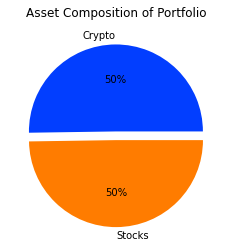

In [12]:
# Plot savings pie chart
# declaring data
data = df_savings['value']
keys = df_savings.index.values
  
# declaring exploding pie
explode = [0, 0.1]

# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
plt.title('Asset Composition of Portfolio')
  
# displaying chart
plt.show()

#Reference: https://www.geeksforgeeks.org/how-to-create-a-pie-chart-in-seaborn/

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3 
#emergency_fund = monthly_income * 10     # Testing the alternate scenario 

# Calculate total amount of savings
total_savings = df_savings['value'].sum()

# Validate saving health
print(f"Emergency Fund: ${emergency_fund:0.2f}\nTotal Savings: ${total_savings:0.2f}\n")
if total_savings >= emergency_fund:
    print(f"Total savings is an adequite emergency fund with ${total_savings - emergency_fund:0.2f} extra.")
else:
    print(f"Total savings is not an adequite emergency fund with ${total_savings - emergency_fund:0.2f} short fall.")


Emergency Fund: $36000.00
Total Savings: $79737.30

Total savings is an adequite emergency fund with $43737.30 extra.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# Set the tickers
tickers = [ticker_AGG, ticker_SPY]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_alpaca = api_alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

#data_alpaca

# Reorganize the DataFrame - Separate ticker data
df_alpaca_AGG = df_alpaca[df_alpaca['symbol'] == ticker_AGG].drop('symbol', axis = 'columns')
df_alpaca_SPY = df_alpaca[df_alpaca['symbol'] == ticker_SPY].drop('symbol', axis = 'columns')

# Concatenate the ticker DataFrames
df_alpaca_data = pd.concat([df_alpaca_AGG, df_alpaca_SPY], axis = 'columns', keys = tickers)
df_alpaca_data.index = df_alpaca_data.index.date

# Display sample data
df_alpaca_data

AGG                                                   \
              open      high       low   close   volume trade_count   
2016-05-02  110.74  110.7400  110.5200  110.61  3553939       15119   
2016-05-03  110.89  110.9450  110.7500  110.81  3044940       15662   
2016-05-04  110.91  110.9315  110.7595  110.86  2920608       13982   
2016-05-05  110.92  111.1600  110.8010  111.14  3008142       15707   
2016-05-06  111.12  111.1200  110.9700  110.97  2718710       12697   
...            ...       ...       ...     ...      ...         ...   
2021-04-26  114.74  114.8015  114.6500  114.65  3480303       13520   
2021-04-27  114.60  115.1300  114.3700  114.37  3820640       12720   
2021-04-28  114.45  114.4685  114.2000  114.43  7075831       24303   
2021-04-29  114.14  114.3700  114.0900  114.37  6208142       21096   
2021-04-30  114.41  114.5150  114.3300  114.49  6469432       19582   

                           SPY                                       \
                  vwap    open    high       low   close     volume   
2016-05-02  110.627199  206.90  208.18  206.4100  208.03   61908515   
2016-05-03  110.865995  206.50  206.80  205.2800  206.13  106422142   
2016-05-04  110.879063  205.00  205.85  204.4200  204.96   92199810   
2016-05-05  111.028363  205.57  205.98  204.4700  204.95   67597222   
2016-05-06  111.031967  204.04  205.77  203.8800  205.70   89131004   
...                ...     ...     ...       ...     ...        ...   
2021-04-26  114.706244  417.42  418.22  416.8111  417.61   51824860   
2021-04-27  114.498315  417.97  418.14  416.3000  417.52   50297139   
2021-04-28  114.379810  417.84  419.01  416.9000  417.40   50692781   
2021-04-29  114.250702  420.38  420.72  416.4400  420.06   76965583   
2021-04-30  114.456246  417.67  418.54  416.3400  417.30   84731942   

                                    
           trade_count        vwap  
2016-05-02      263580  207.294812  
2016-05-03      377518  206.312060  
2016-05-04      345261  205.090172  
2016-05-05      280622  205.141555  
2016-05-06      340335  204.937074  
...                ...         ...  
2021-04-26      295870  417.508245  
2021-04-27      296300  417.481360  
2021-04-28      330049  417.742098  
2021-04-29      443396  418.824046  
2021-04-30      478844  417.651995  

[1259 rows x 14 columns]

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
trading_years = 30
trading_days_year = 252
#num_sims = 100                # Developing code with 100 simulations
num_sims = 500                 # Requiremnt code with 500 simulations   
portfolio_weight_AGG = .40     # AGG = 40%
portfolio_weight_SPY = .60     # SPY = 60%
security_weights = [portfolio_weight_AGG, portfolio_weight_SPY]   

mc_cum_returns = MCSimulation(
    portfolio_data = df_alpaca_data.copy()
    , weights = security_weights
    , num_simulation = num_sims
    , num_trading_days = trading_days_year * trading_years
)

In [17]:
# Printing the simulation input data
mc_cum_returns.portfolio_data


AGG                                                   \
              open      high       low   close   volume trade_count   
2016-05-02  110.74  110.7400  110.5200  110.61  3553939       15119   
2016-05-03  110.89  110.9450  110.7500  110.81  3044940       15662   
2016-05-04  110.91  110.9315  110.7595  110.86  2920608       13982   
2016-05-05  110.92  111.1600  110.8010  111.14  3008142       15707   
2016-05-06  111.12  111.1200  110.9700  110.97  2718710       12697   
...            ...       ...       ...     ...      ...         ...   
2021-04-26  114.74  114.8015  114.6500  114.65  3480303       13520   
2021-04-27  114.60  115.1300  114.3700  114.37  3820640       12720   
2021-04-28  114.45  114.4685  114.2000  114.43  7075831       24303   
2021-04-29  114.14  114.3700  114.0900  114.37  6208142       21096   
2021-04-30  114.41  114.5150  114.3300  114.49  6469432       19582   

                                        SPY                            \
                  vwap daily_return    open    high       low   close   
2016-05-02  110.627199          NaN  206.90  208.18  206.4100  208.03   
2016-05-03  110.865995     0.001808  206.50  206.80  205.2800  206.13   
2016-05-04  110.879063     0.000451  205.00  205.85  204.4200  204.96   
2016-05-05  111.028363     0.002526  205.57  205.98  204.4700  204.95   
2016-05-06  111.031967    -0.001530  204.04  205.77  203.8800  205.70   
...                ...          ...     ...     ...       ...     ...   
2021-04-26  114.706244    -0.000871  417.42  418.22  416.8111  417.61   
2021-04-27  114.498315    -0.002442  417.97  418.14  416.3000  417.52   
2021-04-28  114.379810     0.000525  417.84  419.01  416.9000  417.40   
2021-04-29  114.250702    -0.000524  420.38  420.72  416.4400  420.06   
2021-04-30  114.456246     0.001049  417.67  418.54  416.3400  417.30   

                                                            
               volume trade_count        vwap daily_return  
2016-05-02   61908515      263580  207.294812          NaN  
2016-05-03  106422142      377518  206.312060    -0.009133  
2016-05-04   92199810      345261  205.090172    -0.005676  
2016-05-05   67597222      280622  205.141555    -0.000049  
2016-05-06   89131004      340335  204.937074     0.003659  
...               ...         ...         ...          ...  
2021-04-26   51824860      295870  417.508245     0.002088  
2021-04-27   50297139      296300  417.481360    -0.000216  
2021-04-28   50692781      330049  417.742098    -0.000287  
2021-04-29   76965583      443396  418.824046     0.006373  
2021-04-30   84731942      478844  417.651995    -0.006570  

[1259 rows x 16 columns]

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
warnings.filterwarnings('ignore')          # Turn warnings off for speed

mc_cum_returns.calc_cumulative_return()

warnings.filterwarnings('default')         # Turn warnings back on
print('OK Done')

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.
OK Done


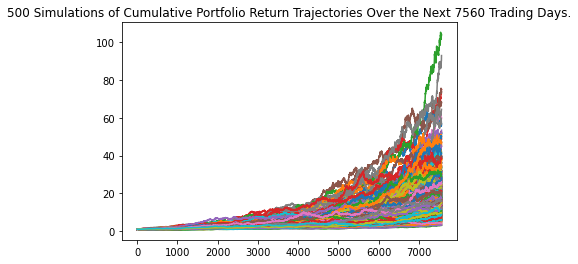

In [19]:
# Plot simulation outcomes
line_plot = mc_cum_returns.plot_simulation()


Note: Distribution Plot appears to be Descrete but is actually Continuous.



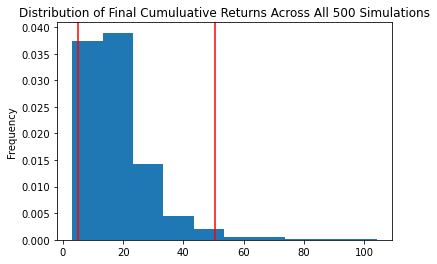

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = mc_cum_returns.plot_distribution()

print('\nNote: Distribution Plot appears to be Descrete but is actually Continuous.\n')

In [21]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    "mean": list(mc_cum_returns.simulated_return.mean(axis=1)),
    "median": list(mc_cum_returns.simulated_return.median(axis=1)),
    "min": list(mc_cum_returns.simulated_return.min(axis=1)),
    "max": list(mc_cum_returns.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
display(df_simulated_returns)

# Rough-Cut Check - Mean Expected Return
mean_data = mc_cum_returns.portfolio_data.mean()
#print(mean_data)                 # View the summary statistics data
#print(type(mean_data))           # Identify the object type to determine how to access it
#print(mean_data.index)           # identify the index values to select the data point of interest

mean_daily_Return_AGG = mean_data[('AGG','daily_return')]
mean_daily_Return_SPY = mean_data[('SPY','daily_return')]
weighted_daily_Return_portfolio = (mean_daily_Return_AGG * .4) + (mean_daily_Return_SPY * .6)

print(f"AGG Average Daily Returns @ 40%: {(mean_daily_Return_AGG * .4):,.6f} \n"
      f"SPY Average Daily Returns @ 60%: {(mean_daily_Return_SPY * .6):,.6f} \n"
      f"Portfolio Weighted Average Daily Returns: {(weighted_daily_Return_portfolio):,.6f} \n"
      f"Simple Estimate of {trading_years}yr Mean Return: {((1 + weighted_daily_Return_portfolio) ** (trading_years * trading_days_year)) *100:,.0f}% \n"
      f"Monte Carlo Estimate of {trading_years}yr Mean Return: {(df_simulated_returns.iloc[-1]['mean']) *100:,.0f}%")

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.000365,1.000208,0.977995,1.017842
2,1.001192,1.001432,0.969138,1.033590
3,1.001752,1.001733,0.961973,1.037781
4,1.002716,1.002613,0.962520,1.046303
...,...,...,...,...
7556,18.257823,15.509788,2.995859,103.337389
7557,18.268268,15.556184,2.981240,103.796822
7558,18.265641,15.509141,2.976461,103.498527
7559,18.269779,15.519211,3.010506,103.856230


AGG Average Daily Returns @ 40%: 0.000013 
SPY Average Daily Returns @ 60%: 0.000375 
Portfolio Weighted Average Daily Returns: 0.000387 
Simple Estimate of 30yr Mean Return: 1,868% 
Monte Carlo Estimate of 30yr Mean Return: 1,828%


### Retirement Analysis

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
tbl = mc_cum_returns.summarize_cumulative_return()
#print(tbl)                 # View the summary statistics data
#print(type(tbl))           # Identify the object type to determine how to access it
#print(tbl.index)           # identify the index values to select the data point of interest

ci_lower = round(tbl['95% CI Lower'] * initial_investment, 2 )
ci_upper = round(tbl['95% CI Upper'] * initial_investment, 2 )

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next {trading_years} years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $102715.21 and $1007031.39


C:\Users\jersk\003_FinTech\git\ftb05_APIs_Challenge\code\MCForecastTools.py:173: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = initial_investment * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl['95% CI Lower'] * initial_investment, 2 )
ci_upper = round(tbl['95% CI Upper'] * initial_investment, 2 )

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.0f} in the portfolio"
      f" over the next {trading_years} years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30,000 in the portfolio over the next 30 years will end within in the range of $154072.81 and $1510547.08


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
trading_years = 5
trading_days_year = 252
#num_sims = 100                # Developing code with 100 simulations
num_sims = 500                 # Requiremnt code with 500 simulations   
portfolio_weight_AGG = .40     # AGG = 40%
portfolio_weight_SPY = .60     # SPY = 60%
security_weights = [portfolio_weight_AGG, portfolio_weight_SPY]   

mc_cum_returns = MCSimulation(
    portfolio_data = df_alpaca_data.copy()
    , weights = security_weights
    , num_simulation = num_sims
    , num_trading_days = trading_days_year * trading_years
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
warnings.filterwarnings('ignore')          # Turn warnings off for speed

mc_cum_returns.calc_cumulative_return()

warnings.filterwarnings('default')         # Turn warnings back on
print('OK Done')

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.
OK Done


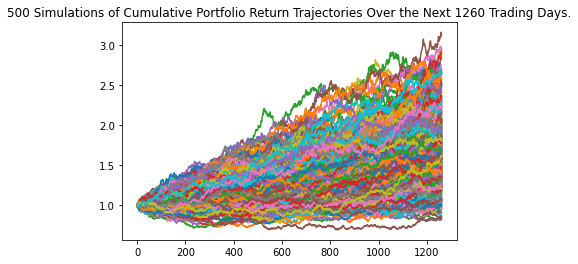

In [26]:
# Plot simulation outcomes
line_plot = mc_cum_returns.plot_simulation()


Note: Distribution Plot appears to be Descrete but is actually Continuous.



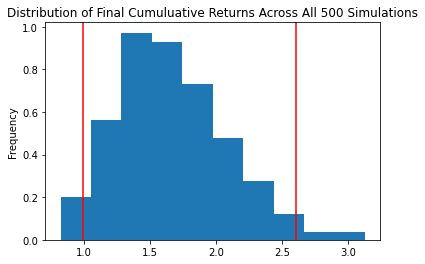

In [27]:
# Plot probability distribution and confidence intervals
dist_plot = mc_cum_returns.plot_distribution()

print('\nNote: Distribution Plot appears to be Descrete but is actually Continuous.\n')

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
simulated_returns_data = {
    "mean": list(mc_cum_returns.simulated_return.mean(axis=1)),
    "median": list(mc_cum_returns.simulated_return.median(axis=1)),
    "min": list(mc_cum_returns.simulated_return.min(axis=1)),
    "max": list(mc_cum_returns.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
display(df_simulated_returns)

# Rough-Cut Check - Mean Expected Return
mean_data = mc_cum_returns.portfolio_data.mean()
#print(mean_data)                 # View the summary statistics data
#print(type(mean_data))           # Identify the object type to determine how to access it
#print(mean_data.index)           # identify the index values to select the data point of interest

mean_daily_Return_AGG = mean_data[('AGG','daily_return')]
mean_daily_Return_SPY = mean_data[('SPY','daily_return')]
weighted_daily_Return_portfolio = (mean_daily_Return_AGG * .4) + (mean_daily_Return_SPY * .6)

print(f"AGG Average Daily Returns @ 40%: {(mean_daily_Return_AGG * .4):,.6f} \n"
      f"SPY Average Daily Returns @ 60%: {(mean_daily_Return_SPY * .6):,.6f} \n"
      f"Portfolio Weighted Average Daily Returns: {(weighted_daily_Return_portfolio):,.6f} \n"
      f"Simple Estimate of {trading_years}yr Mean Return: {((1 + weighted_daily_Return_portfolio) ** (trading_years * trading_days_year)) *100:,.1f}% \n"
      f"Monte Carlo Estimate of {trading_years}yr Mean Return: {(df_simulated_returns.iloc[-1]['mean']) *100:,.1f}%")

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.000337,1.000584,0.982654,1.018572
2,1.000451,1.000907,0.974133,1.028920
3,1.000540,1.000360,0.968139,1.038375
4,1.000724,1.000870,0.958553,1.043406
...,...,...,...,...
1256,1.662250,1.628445,0.816951,3.103784
1257,1.662611,1.628812,0.818459,3.102325
1258,1.662778,1.625492,0.819358,3.140610
1259,1.662755,1.614045,0.819603,3.159968


AGG Average Daily Returns @ 40%: 0.000013 
SPY Average Daily Returns @ 60%: 0.000375 
Portfolio Weighted Average Daily Returns: 0.000387 
Simple Estimate of 5yr Mean Return: 162.9% 
Monte Carlo Estimate of 5yr Mean Return: 166.3%


In [29]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
tbl = mc_cum_returns.summarize_cumulative_return()
#print(tbl)                 # View the summary statistics data
#print(type(tbl))           # Identify the object type to determine how to access it
#print(tbl.index)           # identify the index values to select the data point of interest

ci_lower_five = round(tbl['95% CI Lower'] * initial_investment, 2 )
ci_upper_five = round(tbl['95% CI Upper'] * initial_investment, 2 )


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next {trading_years} years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $59423.97 and $156496.12


C:\Users\jersk\003_FinTech\git\ftb05_APIs_Challenge\code\MCForecastTools.py:173: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
trading_years = 10
trading_days_year = 252
#num_sims = 100                # Developing code with 100 simulations
num_sims = 500                 # Requiremnt code with 500 simulations   
portfolio_weight_AGG = .40     # AGG = 40%
portfolio_weight_SPY = .60     # SPY = 60%
security_weights = [portfolio_weight_AGG, portfolio_weight_SPY]   

mc_cum_returns = MCSimulation(
    portfolio_data = df_alpaca_data.copy()
    , weights = security_weights
    , num_simulation = num_sims
    , num_trading_days = trading_days_year * trading_years
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
warnings.filterwarnings('ignore')          # Turn warnings off for speed

mc_cum_returns.calc_cumulative_return()

warnings.filterwarnings('default')         # Turn warnings back on
print('OK Done')

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.
OK Done


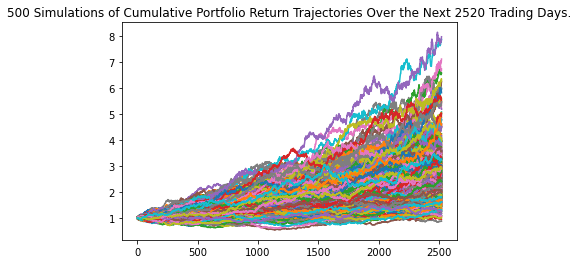

In [32]:
# Plot simulation outcomes
line_plot = mc_cum_returns.plot_simulation()


Note: Distribution Plot appears to be Descrete but is actually Continuous.



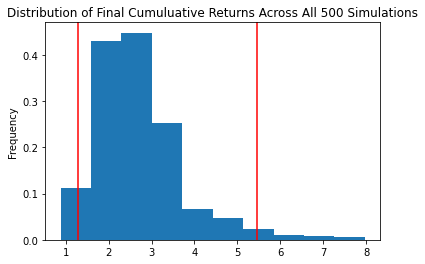

In [33]:
# Plot probability distribution and confidence intervals
dist_plot = mc_cum_returns.plot_distribution()

print('\nNote: Distribution Plot appears to be Descrete but is actually Continuous.\n')

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
simulated_returns_data = {
    "mean": list(mc_cum_returns.simulated_return.mean(axis=1)),
    "median": list(mc_cum_returns.simulated_return.median(axis=1)),
    "min": list(mc_cum_returns.simulated_return.min(axis=1)),
    "max": list(mc_cum_returns.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
display(df_simulated_returns)

# Rough-Cut Check - Mean Expected Return
mean_data = mc_cum_returns.portfolio_data.mean()
#print(mean_data)                 # View the summary statistics data
#print(type(mean_data))           # Identify the object type to determine how to access it
#print(mean_data.index)           # identify the index values to select the data point of interest

mean_daily_Return_AGG = mean_data[('AGG','daily_return')]
mean_daily_Return_SPY = mean_data[('SPY','daily_return')]
weighted_daily_Return_portfolio = (mean_daily_Return_AGG * .4) + (mean_daily_Return_SPY * .6)

print(f"AGG Average Daily Returns @ 40%: {(mean_daily_Return_AGG * .4):,.6f} \n"
      f"SPY Average Daily Returns @ 60%: {(mean_daily_Return_SPY * .6):,.6f} \n"
      f"Portfolio Weighted Average Daily Returns: {(weighted_daily_Return_portfolio):,.6f} \n"
      f"Simple Estimate of {trading_years}yr Mean Return: {((1 + weighted_daily_Return_portfolio) ** (trading_years * trading_days_year)) *100:,.1f}% \n"
      f"Monte Carlo Estimate of {trading_years}yr Mean Return: {(df_simulated_returns.iloc[-1]['mean']) *100:,.1f}%")

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.000692,1.000561,0.979537,1.021924
2,1.001117,1.001994,0.962921,1.029065
3,1.001400,1.001009,0.960927,1.036097
4,1.001817,1.001236,0.963492,1.043154
...,...,...,...,...
2516,2.698494,2.525951,0.871916,7.817316
2517,2.697831,2.522571,0.880648,7.781680
2518,2.700962,2.523694,0.876282,7.904568
2519,2.703194,2.536772,0.877783,7.925972


AGG Average Daily Returns @ 40%: 0.000013 
SPY Average Daily Returns @ 60%: 0.000375 
Portfolio Weighted Average Daily Returns: 0.000387 
Simple Estimate of 10yr Mean Return: 265.4% 
Monte Carlo Estimate of 10yr Mean Return: 270.4%


In [35]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
tbl = mc_cum_returns.summarize_cumulative_return()
#print(tbl)                 # View the summary statistics data
#print(type(tbl))           # Identify the object type to determine how to access it
#print(tbl.index)           # identify the index values to select the data point of interest

ci_lower_ten = round(tbl['95% CI Lower'] * initial_investment, 2 )
ci_upper_ten = round(tbl['95% CI Upper'] * initial_investment, 2 )

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next {trading_years} years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $77205.99 and $327271.97


C:\Users\jersk\003_FinTech\git\ftb05_APIs_Challenge\code\MCForecastTools.py:173: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)
